In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 200)

plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams["axes.unicode_minus"] = False


In [3]:
# 프로젝트 루트 기준
ROOT = Path(".").resolve()

RAW_DIR = ROOT / "data" / "raw"

# traffic raw 파일 패턴
FILE_PATTERN = "traffic_history_with_spots_*.csv"

RAW_DIR


WindowsPath('C:/NEW/traffic-volume/data/raw')

In [4]:
def read_csv_robust(path: Path) -> pd.DataFrame:
    for enc in ["utf-8-sig", "cp949", "euc-kr"]:
        try:
            return pd.read_csv(path, encoding=enc)
        except:
            pass
    raise ValueError(f"CSV 로드 실패: {path}")


In [5]:
files = sorted(RAW_DIR.glob(FILE_PATTERN))

if not files:
    raise RuntimeError("교통량 raw 파일을 찾을 수 없습니다.")

print("로드 대상 파일:")
for f in files:
    print("-", f.name)

dfs = []
for f in files:
    df = read_csv_robust(f)
    df["source_file"] = f.name
    dfs.append(df)

raw = pd.concat(dfs, ignore_index=True)

raw.shape


로드 대상 파일:
- traffic_history_with_spots_20240101_20240631_A1_A13.csv
- traffic_history_with_spots_20240101_20241231_D46_F10.csv
- traffic_history_with_spots_20240701_20241231_A1_A13.csv


(1144173, 10)

In [6]:
raw.head()


,spot_num,ymd,hh,io_type,lane_num,vol,spot_nm,grs80tm_x,grs80tm_y,source_file
0,A-01,20240101,0,1,1,167,성산로(금화터널),195489.0,452136.0,traffic_history_with_spots_20240101_20240631_A...
1,A-01,20240101,0,1,2,360,성산로(금화터널),195489.0,452136.0,traffic_history_with_spots_20240101_20240631_A...
2,A-01,20240101,0,2,1,689,성산로(금화터널),195489.0,452136.0,traffic_history_with_spots_20240101_20240631_A...
3,A-01,20240101,0,2,2,520,성산로(금화터널),195489.0,452136.0,traffic_history_with_spots_20240101_20240631_A...
4,A-01,20240101,1,1,1,159,성산로(금화터널),195489.0,452136.0,traffic_history_with_spots_20240101_20240631_A...


In [7]:
raw.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1144173 entries, 0 to 1144172
Data columns (total 10 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   spot_num     1144173 non-null  object 
 1   ymd          1144173 non-null  int64  
 2   hh           1144173 non-null  int64  
 3   io_type      1144173 non-null  int64  
 4   lane_num     1144173 non-null  int64  
 5   vol          1144173 non-null  int64  
 6   spot_nm      1144173 non-null  object 
 7   grs80tm_x    1144173 non-null  float64
 8   grs80tm_y    1144173 non-null  float64
 9   source_file  1144173 non-null  object 
dtypes: float64(2), int64(5), object(3)
memory usage: 87.3+ MB


In [8]:
df = raw.copy()

def rename_if_exists(df, candidates, target):
    for c in candidates:
        if c in df.columns:
            return df.rename(columns={c: target})
    raise RuntimeError(f"{target} 컬럼을 찾지 못함")

df = rename_if_exists(df, ["spot_num", "SPOT_NUM", "spotNo", "spot_id"], "spot_num")
df = rename_if_exists(df, ["ymd", "YMD", "date"], "ymd")
df = rename_if_exists(df, ["hh", "HH", "hour"], "hh")
df = rename_if_exists(df, ["vol", "VOL", "volume", "traffic"], "vol")

df["spot_num"] = df["spot_num"].astype(str)
df["ymd"] = df["ymd"].astype(str)
df["hh"] = pd.to_numeric(df["hh"], errors="coerce")
df["vol"] = pd.to_numeric(df["vol"], errors="coerce")

df[["spot_num", "ymd", "hh", "vol"]].head()


,spot_num,ymd,hh,vol
0,A-01,20240101,0,167
1,A-01,20240101,0,360
2,A-01,20240101,0,689
3,A-01,20240101,0,520
4,A-01,20240101,1,159


In [9]:
hourly = (
    df.groupby(["spot_num", "ymd", "hh"], as_index=False)["vol"]
      .sum()
)

hourly["datetime"] = pd.to_datetime(
    hourly["ymd"] + hourly["hh"].astype(int).astype(str).str.zfill(2),
    format="%Y%m%d%H",
    errors="coerce"
)

hourly = hourly.dropna(subset=["datetime"])
hourly = hourly[["spot_num", "datetime", "vol"]]

hourly.head()


,spot_num,datetime,vol
0,A-01,2024-01-01 00:00:00,1736
1,A-01,2024-01-01 01:00:00,1433
2,A-01,2024-01-01 02:00:00,753
3,A-01,2024-01-01 03:00:00,456
4,A-01,2024-01-01 04:00:00,468


In [10]:
data = hourly.copy()

dt = data["datetime"]

data["hour"] = dt.dt.hour
data["dow"] = dt.dt.dayofweek
data["is_weekend"] = (data["dow"] >= 5).astype(int)

data["hour_sin"] = np.sin(2 * np.pi * data["hour"] / 24)
data["hour_cos"] = np.cos(2 * np.pi * data["hour"] / 24)

data["dow_sin"] = np.sin(2 * np.pi * data["dow"] / 7)
data["dow_cos"] = np.cos(2 * np.pi * data["dow"] / 7)

data.head()


,spot_num,datetime,vol,hour,dow,is_weekend,hour_sin,hour_cos,dow_sin,dow_cos
0,A-01,2024-01-01 00:00:00,1736,0,0,0,0.000000,1.000000,0.0,1.0
1,A-01,2024-01-01 01:00:00,1433,1,0,0,0.258819,0.965926,0.0,1.0
2,A-01,2024-01-01 02:00:00,753,2,0,0,0.500000,0.866025,0.0,1.0
3,A-01,2024-01-01 03:00:00,456,3,0,0,0.707107,0.707107,0.0,1.0
4,A-01,2024-01-01 04:00:00,468,4,0,0,0.866025,0.500000,0.0,1.0


In [11]:
summary = {
    "전체 행 수": len(data),
    "결측 셀 수": int(data.isnull().sum().sum()),
    "결측 비율(%)": round(data.isnull().mean().mean() * 100, 3),
    "중복 행 수": int(data.duplicated().sum()),
    "중복 비율(%)": round(data.duplicated().mean() * 100, 3)
}

pd.DataFrame([summary])


,전체 행 수,결측 셀 수,결측 비율(%),중복 행 수,중복 비율(%)
0,206557,0,0.0,0,0.0


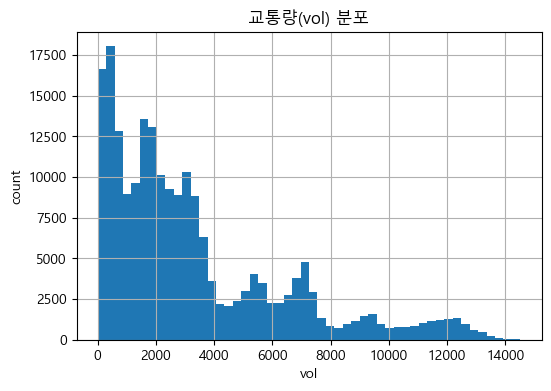

In [12]:
plt.figure(figsize=(6,4))
data["vol"].hist(bins=50)
plt.title("교통량(vol) 분포")
plt.xlabel("vol")
plt.ylabel("count")
plt.show()


In [13]:
# 기상 데이터 경로 예시
WEATHER_PATH = ROOT / "data" / "raw" / "weather_seoul_108.csv"

weather = read_csv_robust(WEATHER_PATH)
weather.head()


,지점,지점명,일시,기온(°C),강수량(mm),풍속(m/s),풍향(16방위),습도(%),현지기압(hPa),일조(hr),적설(cm),3시간신적설(cm),전운량(10분위),중하층운량(10분위),지면상태(지면상태코드),지면온도(°C)
0,108,서울,2024-01-01 01:00,0.5,NaN,2.2,50.0,97,1015.6,NaN,2.4,NaN,0,0,NaN,-0.2
1,108,서울,2024-01-01 02:00,0.4,NaN,0.4,0.0,98,1016.2,NaN,2.4,NaN,6,2,NaN,-0.3
2,108,서울,2024-01-01 03:00,-0.1,NaN,1.7,20.0,98,1016.6,NaN,2.4,NaN,1,1,NaN,-0.3
3,108,서울,2024-01-01 04:00,-0.2,NaN,2.2,20.0,98,1016.8,NaN,2.4,NaN,6,6,NaN,-0.3
4,108,서울,2024-01-01 05:00,0.3,NaN,1.2,90.0,99,1017.2,NaN,2.4,NaN,8,8,NaN,-0.2


In [14]:
# 예시: '일시' 컬럼이 있는 경우
weather["datetime"] = pd.to_datetime(weather["일시"], errors="coerce")

# 숫자형 변환
num_cols = weather.columns.drop(["일시", "datetime"])
for c in num_cols:
    weather[c] = pd.to_numeric(weather[c], errors="coerce")

weather = weather.dropna(subset=["datetime"])
weather.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8783 entries, 0 to 8782
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   지점            8783 non-null   int64         
 1   지점명           0 non-null      float64       
 2   일시            8783 non-null   object        
 3   기온(°C)        8783 non-null   float64       
 4   강수량(mm)       956 non-null    float64       
 5   풍속(m/s)       8752 non-null   float64       
 6   풍향(16방위)      8752 non-null   float64       
 7   습도(%)         8783 non-null   int64         
 8   현지기압(hPa)     8783 non-null   float64       
 9   일조(hr)        4784 non-null   float64       
 10  적설(cm)        442 non-null    float64       
 11  3시간신적설(cm)    40 non-null     float64       
 12  전운량(10분위)     8783 non-null   int64         
 13  중하층운량(10분위)   8783 non-null   int64         
 14  지면상태(지면상태코드)  0 non-null      float64       
 15  지면온도(°C)      8783 non-null   float64 

In [15]:
data_merged = data.merge(
    weather,
    on="datetime",
    how="left"
)

data_merged.head()


,spot_num,datetime,vol,hour,dow,is_weekend,hour_sin,hour_cos,dow_sin,dow_cos,지점,지점명,일시,기온(°C),강수량(mm),풍속(m/s),풍향(16방위),습도(%),현지기압(hPa),일조(hr),적설(cm),3시간신적설(cm),전운량(10분위),중하층운량(10분위),지면상태(지면상태코드),지면온도(°C)
0,A-01,2024-01-01 00:00:00,1736,0,0,0,0.000000,1.000000,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,A-01,2024-01-01 01:00:00,1433,1,0,0,0.258819,0.965926,0.0,1.0,108.0,NaN,2024-01-01 01:00,0.5,NaN,2.2,50.0,97.0,1015.6,NaN,2.4,NaN,0.0,0.0,NaN,-0.2
2,A-01,2024-01-01 02:00:00,753,2,0,0,0.500000,0.866025,0.0,1.0,108.0,NaN,2024-01-01 02:00,0.4,NaN,0.4,0.0,98.0,1016.2,NaN,2.4,NaN,6.0,2.0,NaN,-0.3
3,A-01,2024-01-01 03:00:00,456,3,0,0,0.707107,0.707107,0.0,1.0,108.0,NaN,2024-01-01 03:00,-0.1,NaN,1.7,20.0,98.0,1016.6,NaN,2.4,NaN,1.0,1.0,NaN,-0.3
4,A-01,2024-01-01 04:00:00,468,4,0,0,0.866025,0.500000,0.0,1.0,108.0,NaN,2024-01-01 04:00,-0.2,NaN,2.2,20.0,98.0,1016.8,NaN,2.4,NaN,6.0,6.0,NaN,-0.3


In [16]:
# 강수량, 적설은 결측이면 0
for c in ["강수량(mm)", "적설(cm)"]:
    if c in data_merged.columns:
        data_merged[c] = data_merged[c].fillna(0)

# 나머지 기상 변수는 ffill/bfill
weather_vars = weather.columns.drop(["일시", "datetime"])
data_merged[weather_vars] = (
    data_merged
    .sort_values("datetime")
    .groupby("spot_num")[weather_vars]
    .ffill()
    .bfill()
)


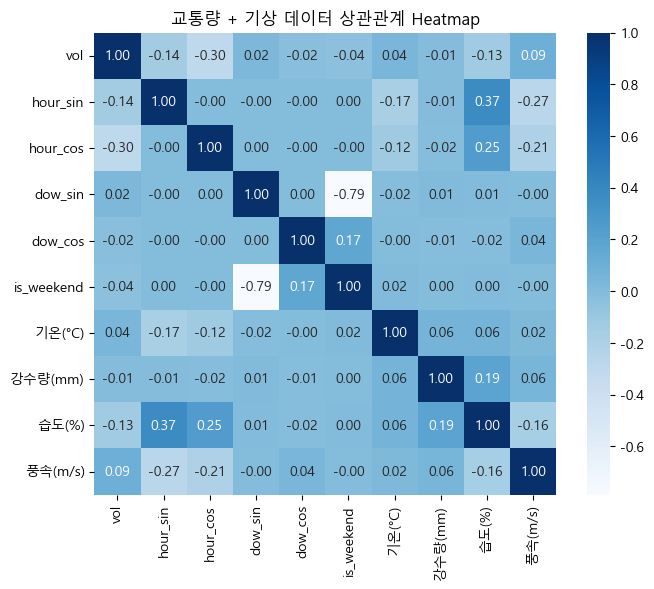

In [17]:
# Heatmap에 사용할 컬럼 선택
corr_cols = [
    "vol",
    "hour_sin", "hour_cos",
    "dow_sin", "dow_cos",
    "is_weekend",
    "기온(°C)",
    "강수량(mm)",
    "습도(%)",
    "풍속(m/s)"
]

corr_cols = [c for c in corr_cols if c in data_merged.columns]

corr = data_merged[corr_cols].corr()

plt.figure(figsize=(8,6))
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    square=True
)
plt.title("교통량 + 기상 데이터 상관관계 Heatmap")
plt.show()


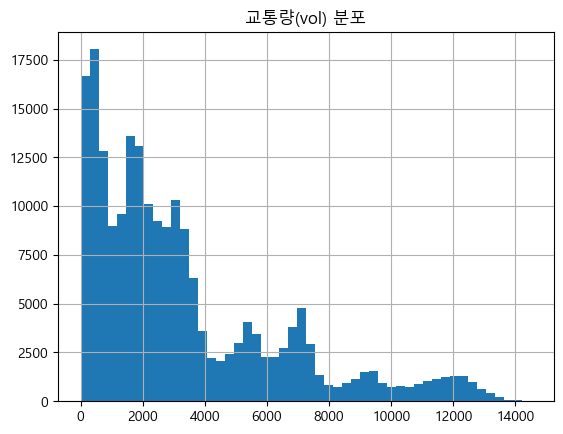

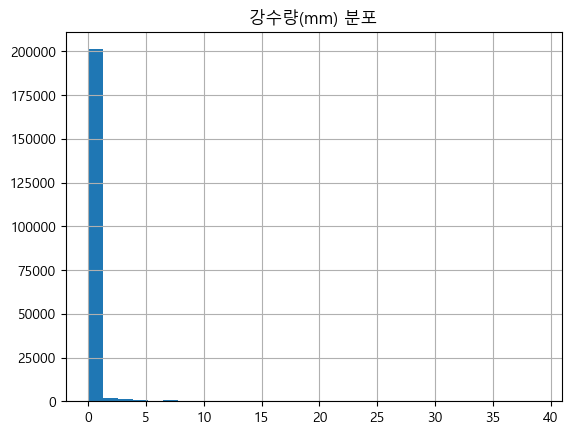

In [18]:
# 타겟 분포
data["vol"].hist(bins=50)
plt.title("교통량(vol) 분포")
plt.show()

# 강수량 분포 (참고용)
if "강수량(mm)" in data_merged.columns:
    data_merged["강수량(mm)"].hist(bins=30)
    plt.title("강수량(mm) 분포")
    plt.show()


In [23]:
from pathlib import Path
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models

ROOT = Path(".").resolve()
npz_raw = ROOT / "data" / "processed" / "windows_w168_h1_tf_sid_wx_raw.npz"
npz_rnn = ROOT / "data" / "processed" / "windows_w168_h1_tf_sid_wx_logscaled.npz"

def load_npz(npz_path: Path):
    d = np.load(npz_path, allow_pickle=True)
    X_train, y_train = d["X_train"], d["y_train"]
    X_val, y_val     = d["X_val"], d["y_val"]
    X_test, y_test   = d["X_test"], d["y_test"]
    feature_cols = d["feature_cols"].tolist() if "feature_cols" in d else None
    meta = {
        "target_transform": (d["target_transform"].tolist() if "target_transform" in d else ["none"]),
        "scaler_mean": float(d["scaler_mean"][0]) if "scaler_mean" in d else None,
        "scaler_std": float(d["scaler_std"][0]) if "scaler_std" in d else None,
        "scaler_vol_index": int(d["scaler_vol_index"][0]) if "scaler_vol_index" in d else None,
    }
    return X_train, y_train, X_val, y_val, X_test, y_test, feature_cols, meta

Xtr_rnn, ytr_rnn, Xva_rnn, yva_rnn, Xte_rnn, yte_rnn, feat_cols_rnn, meta_rnn = load_npz(npz_rnn)

print("RNN X_train shape:", Xtr_rnn.shape)  # (N, window, n_features)
print("RNN y_train shape:", ytr_rnn.shape)
print("feature cols:", feat_cols_rnn[:10], "..." if feat_cols_rnn and len(feat_cols_rnn) > 10 else "")


RNN X_train shape: (143539, 168, 25)
RNN y_train shape: (143539, 1)
feature cols: ['vol', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'month_sin', 'month_cos', 'is_weekend', 'temp_c', 'rain_mm'] ...


In [ ]:
# optional
try:
    from xgboost import XGBRegressor
    XGB_AVAILABLE = True
except Exception:
    XGB_AVAILABLE = False

def define_xgb_model(random_state=42):
    if not XGB_AVAILABLE:
        return None
    model = XGBRegressor(
        n_estimators=800,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.9,
        colsample_bytree=0.9,
        objective="reg:squarederror",
        random_state=random_state,
        n_jobs=0,
        importance_type="gain",
    )
    return model

xgb_model = define_xgb_model()
xgb_model


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.9
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [24]:
def load_spot_ids_from_raw(npz_raw_path: Path, expected_feature_cols: list[str]):
    d = np.load(npz_raw_path, allow_pickle=True)
    X_train, X_val, X_test = d["X_train"], d["X_val"], d["X_test"]
    feature_cols = d["feature_cols"].tolist()

    if feature_cols != expected_feature_cols:
        raise RuntimeError("raw npz와 rnn npz의 feature_cols가 다릅니다.")

    if "spot_id" not in feature_cols:
        return None

    idx = feature_cols.index("spot_id")
    s_tr = np.rint(X_train[:, 0, idx]).astype(np.int32)
    s_va = np.rint(X_val[:, 0, idx]).astype(np.int32)
    s_te = np.rint(X_test[:, 0, idx]).astype(np.int32)
    return s_tr, s_va, s_te

def drop_spot_id_feature(X: np.ndarray, feature_cols: list[str]):
    if "spot_id" not in feature_cols:
        return X, feature_cols
    idx = feature_cols.index("spot_id")
    X2 = np.delete(X, idx, axis=2)
    cols2 = [c for i, c in enumerate(feature_cols) if i != idx]
    return X2, cols2


In [25]:
# spot_id 분리
s_tr, s_va, s_te = load_spot_ids_from_raw(npz_raw, feat_cols_rnn)

# seq 입력에서는 spot_id 제거
Xtr_seq, seq_cols = drop_spot_id_feature(Xtr_rnn, feat_cols_rnn)
Xva_seq, _ = drop_spot_id_feature(Xva_rnn, feat_cols_rnn)
Xte_seq, _ = drop_spot_id_feature(Xte_rnn, feat_cols_rnn)

timesteps = Xtr_seq.shape[1]
n_seq_features = Xtr_seq.shape[2]
num_spots = int(max(s_tr.max(), s_va.max(), s_te.max()) + 1)

print("seq shape:", Xtr_seq.shape, "timesteps:", timesteps, "n_features:", n_seq_features, "num_spots:", num_spots)


seq shape: (143539, 168, 24) timesteps: 168 n_features: 24 num_spots: 24


In [26]:
def build_lstm_with_spot_embedding(
    timesteps: int,
    n_seq_features: int,
    num_spots: int,
    embed_dim: int = 8,
    hidden1: int = 64,
    hidden2: int = 32,
    dropout: float = 0.2,
    lr: float = 1e-3
):
    seq_in = layers.Input(shape=(timesteps, n_seq_features), name="seq_in")
    spot_in = layers.Input(shape=(), dtype="int32", name="spot_id")

    emb = layers.Embedding(input_dim=num_spots, output_dim=embed_dim, name="spot_embedding")(spot_in)
    emb = layers.Flatten()(emb)
    emb = layers.RepeatVector(timesteps)(emb)

    x = layers.Concatenate(axis=-1)([seq_in, emb])

    x = layers.LSTM(hidden1, return_sequences=True, name="lstm_1")(x)
    x = layers.Dropout(dropout, name="drop_1")(x)
    x = layers.LSTM(hidden2, return_sequences=False, name="lstm_2")(x)
    x = layers.Dropout(dropout, name="drop_2")(x)

    out = layers.Dense(1, name="y_hat")(x)

    model = models.Model(inputs=[seq_in, spot_in], outputs=out, name="LSTM_spot")
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss="mse",
        metrics=[tf.keras.metrics.MeanAbsoluteError(name="mae")]
    )
    return model

lstm_model = build_lstm_with_spot_embedding(
    timesteps=timesteps,
    n_seq_features=n_seq_features,
    num_spots=num_spots,
    embed_dim=8
)

lstm_model.summary()


Model: "LSTM_spot"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ spot_id             │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spot_embedding      │ (None, 8)         │        192 │ spot_id[0][0]     │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 8)         │          0 │ spot_embedding[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ seq_in (InputLayer) │ (None, 168, 24)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector       │ (None, 168, 8)    │          0 │ flatten[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 168, 32)   │          0 │ seq_in[0][0],     │
│ (Concatenate)       │                   │            │ repeat_vector[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 168, 64)   │     24,832 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ drop_1 (Dropout)    │ (None, 168, 64)   │          0 │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 32)        │     12,416 │ drop_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ drop_2 (Dropout)    │ (None, 32)        │          0 │ lstm_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ y_hat (Dense)       │ (None, 1)         │         33 │ drop_2[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 37,473 (146.38 KB)

 Trainable params: 37,473 (146.38 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
def build_gru_with_spot_embedding(
    timesteps: int,
    n_seq_features: int,
    num_spots: int,
    embed_dim: int = 8,
    hidden1: int = 64,
    hidden2: int = 32,
    dropout: float = 0.2,
    lr: float = 1e-3
):
    seq_in = layers.Input(shape=(timesteps, n_seq_features), name="seq_in")
    spot_in = layers.Input(shape=(), dtype="int32", name="spot_id")

    emb = layers.Embedding(input_dim=num_spots, output_dim=embed_dim, name="spot_embedding")(spot_in)
    emb = layers.Flatten()(emb)
    emb = layers.RepeatVector(timesteps)(emb)

    x = layers.Concatenate(axis=-1)([seq_in, emb])

    x = layers.GRU(hidden1, return_sequences=True, name="gru_1")(x)
    x = layers.Dropout(dropout, name="drop_1")(x)
    x = layers.GRU(hidden2, return_sequences=False, name="gru_2")(x)
    x = layers.Dropout(dropout, name="drop_2")(x)

    out = layers.Dense(1, name="y_hat")(x)

    model = models.Model(inputs=[seq_in, spot_in], outputs=out, name="GRU_spot")
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss="mse",
        metrics=[tf.keras.metrics.MeanAbsoluteError(name="mae")]
    )
    return model

gru_model = build_gru_with_spot_embedding(
    timesteps=timesteps,
    n_seq_features=n_seq_features,
    num_spots=num_spots,
    embed_dim=8
)

gru_model.summary()


Model: "GRU_spot"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ spot_id             │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spot_embedding      │ (None, 8)         │        192 │ spot_id[0][0]     │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 8)         │          0 │ spot_embedding[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ seq_in (InputLayer) │ (None, 168, 24)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_1     │ (None, 168, 8)    │          0 │ flatten_1[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 168, 32)   │          0 │ seq_in[0][0],     │
│ (Concatenate)       │                   │            │ repeat_vector_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_1 (GRU)         │ (None, 168, 64)   │     18,816 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ drop_1 (Dropout)    │ (None, 168, 64)   │          0 │ gru_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_2 (GRU)         │ (None, 32)        │      9,408 │ drop_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ drop_2 (Dropout)    │ (None, 32)        │          0 │ gru_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ y_hat (Dense)       │ (None, 1)         │         33 │ drop_2[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 28,449 (111.13 KB)

 Trainable params: 28,449 (111.13 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras import callbacks

EPOCHS = 30
BATCH = 256

cbs = [
    callbacks.EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True),
    callbacks.ReduceLROnPlateau(monitor="val_loss", patience=2, factor=0.5, min_lr=1e-5),
]

hist_lstm = lstm_model.fit(
    [Xtr_seq, s_tr], ytr_rnn.reshape(-1,1),
    validation_data=([Xva_seq, s_va], yva_rnn.reshape(-1,1)),
    epochs=EPOCHS,
    batch_size=BATCH,
    callbacks=cbs,
    verbose=1
)

hist_gru = gru_model.fit(
    [Xtr_seq, s_tr], ytr_rnn.reshape(-1,1),
    validation_data=([Xva_seq, s_va], yva_rnn.reshape(-1,1)),
    epochs=EPOCHS,
    batch_size=BATCH,
    callbacks=cbs,
    verbose=1
)


Epoch 1/30
561/561 ━━━━━━━━━━━━━━━━━━━━ 166s 287ms/step - loss: 0.1107 - mae: 0.1936 - val_loss: 0.0435 - val_mae: 0.1155 - learning_rate: 0.0010
Epoch 2/30
561/561 ━━━━━━━━━━━━━━━━━━━━ 158s 282ms/step - loss: 0.0489 - mae: 0.1255 - val_loss: 0.0277 - val_mae: 0.0941 - learning_rate: 0.0010
Epoch 3/30
561/561 ━━━━━━━━━━━━━━━━━━━━ 158s 281ms/step - loss: 0.0420 - mae: 0.1143 - val_loss: 0.0289 - val_mae: 0.0916 - learning_rate: 0.0010
Epoch 4/30
561/561 ━━━━━━━━━━━━━━━━━━━━ 161s 287ms/step - loss: 0.0375 - mae: 0.1077 - val_loss: 0.0438 - val_mae: 0.0992 - learning_rate: 0.0010
Epoch 5/30
561/561 ━━━━━━━━━━━━━━━━━━━━ 159s 284ms/step - loss: 0.0330 - mae: 0.1009 - val_loss: 0.0348 - val_mae: 0.0891 - learning_rate: 5.0000e-04
Epoch 6/30
561/561 ━━━━━━━━━━━━━━━━━━━━ 156s 278ms/step - loss: 0.0315 - mae: 0.0982 - val_loss: 0.0334 - val_mae: 0.0867 - learning_rate: 5.0000e-04
Epoch 7/30
561/561 ━━━━━━━━━━━━━━━━━━━━ 159s 283ms/step - loss: 0.0295 - mae: 0.0951 - val_loss: 0.0339 - val_mae: 0

In [28]:
import matplotlib.pyplot as plt
from pathlib import Path

REPORTS = Path("reports")
REPORTS.mkdir(exist_ok=True)

def plot_history(history, title, outpath: Path):
    h = history.history
    plt.figure(figsize=(6,4))
    plt.plot(h.get("loss", []), label="Training Loss")
    plt.plot(h.get("val_loss", []), label="Validation Loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss (MSE)")
    plt.legend()
    plt.tight_layout()
    plt.savefig(outpath, dpi=200)
    plt.show()

plot_history(hist_lstm, "LSTM Training and Validation Loss", REPORTS / "loss_lstm.png")
plot_history(hist_gru,  "GRU Training and Validation Loss",  REPORTS / "loss_gru.png")


NameError: name 'hist_lstm' is not defined

In [ ]:
import numpy as np

def inverse_target_if_needed(y_scaled: np.ndarray, meta: dict) -> np.ndarray:
    tt = meta.get("target_transform", ["none"])
    tt0 = tt[0] if isinstance(tt, list) and len(tt) else str(tt)

    y = np.asarray(y_scaled).reshape(-1)

    if "log1p" not in str(tt0).lower():
        return y.astype(np.float32)

    mean = meta.get("scaler_mean", None)
    std  = meta.get("scaler_std", None)
    if mean is None or std is None:
        raise RuntimeError("logscaled인데 scaler_mean/std가 meta에 없습니다.")

    y = y * std + mean
    y = np.expm1(y)
    return y.astype(np.float32)


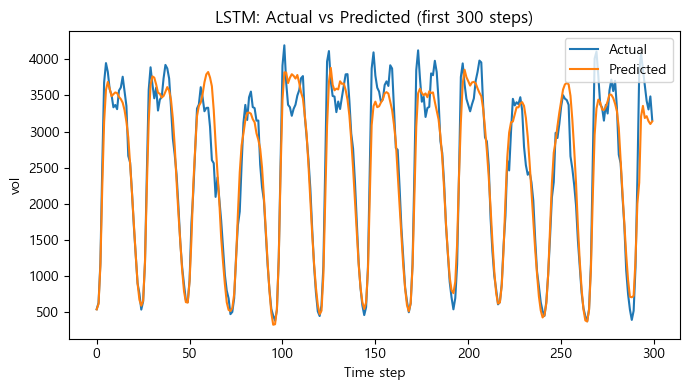

In [ ]:
# (예) LSTM으로 테스트 예측
y_pred_scaled = lstm_model.predict([Xte_seq, s_te], batch_size=256, verbose=0).reshape(-1)
y_true_scaled = yte_rnn.reshape(-1)

y_pred = inverse_target_if_needed(y_pred_scaled, meta_rnn)
y_true = inverse_target_if_needed(y_true_scaled, meta_rnn)

# 보기 좋은 구간만 자르기 (예: 앞 300개)
N = 300
plt.figure(figsize=(7,4))
plt.plot(y_true[:N], label="Actual")
plt.plot(y_pred[:N], label="Predicted")
plt.title("LSTM: Actual vs Predicted (first 300 steps)")
plt.xlabel("Time step")
plt.ylabel("vol")
plt.legend()
plt.tight_layout()
plt.savefig(REPORTS / "pred_vs_actual_lstm_short.png", dpi=200)
plt.show()


In [ ]:
import pandas as pd

hourly = pd.read_csv("data/processed/traffic_hourly.csv", dtype={"spot_num": str}, encoding="utf-8-sig")
hourly["datetime"] = pd.to_datetime(hourly["datetime"])
hourly = hourly.sort_values(["spot_num","datetime"]).reset_index(drop=True)



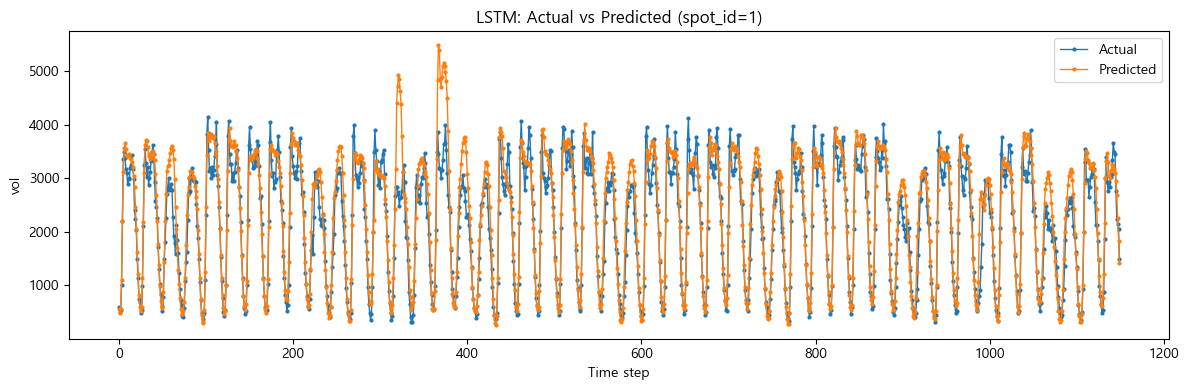

In [ ]:
spot_pick = int(np.bincount(s_te).argmax())  # 테스트에서 가장 많이 등장하는 spot_id
mask = (s_te == spot_pick)

y_true_spot = y_true[mask]
y_pred_spot = y_pred[mask]

# 시간 순서대로 보이게 (테스트 데이터는 이미 시간순으로 생성된 경우가 대부분)
plt.figure(figsize=(12,4))
plt.plot(y_true_spot, label="Actual", marker="o", markersize=2, linewidth=1)
plt.plot(y_pred_spot, label="Predicted", marker="o", markersize=2, linewidth=1)
plt.title(f"LSTM: Actual vs Predicted (spot_id={spot_pick})")
plt.xlabel("Time step")
plt.ylabel("vol")
plt.legend()
plt.tight_layout()
plt.savefig(REPORTS / f"pred_vs_actual_lstm_spot{spot_pick}.png", dpi=200)
plt.show()


In [ ]:
# GRU 테스트 예측
y_pred_scaled_gru = gru_model.predict([Xte_seq, s_te], batch_size=256, verbose=0).reshape(-1)
y_true_scaled = yte_rnn.reshape(-1)

y_pred_gru = inverse_target_if_needed(y_pred_scaled_gru, meta_rnn)
y_true = inverse_target_if_needed(y_true_scaled, meta_rnn)

len(y_true), len(y_pred_gru)


(27591, 27591)

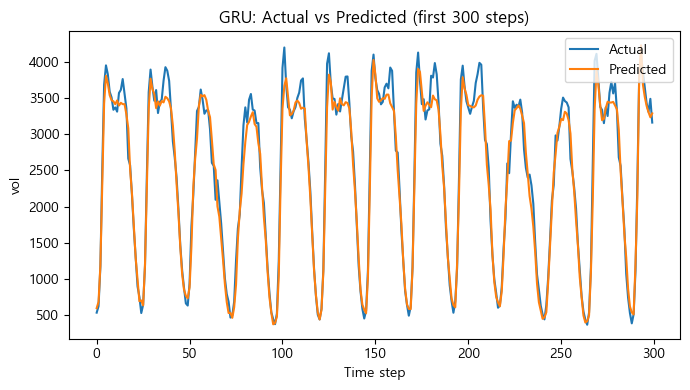

In [ ]:
import matplotlib.pyplot as plt

N = 300
plt.figure(figsize=(7,4))
plt.plot(y_true[:N], label="Actual")
plt.plot(y_pred_gru[:N], label="Predicted")
plt.title("GRU: Actual vs Predicted (first 300 steps)")
plt.xlabel("Time step")
plt.ylabel("vol")
plt.legend()
plt.tight_layout()
plt.savefig(REPORTS / "pred_vs_actual_gru_short.png", dpi=200)
plt.show()


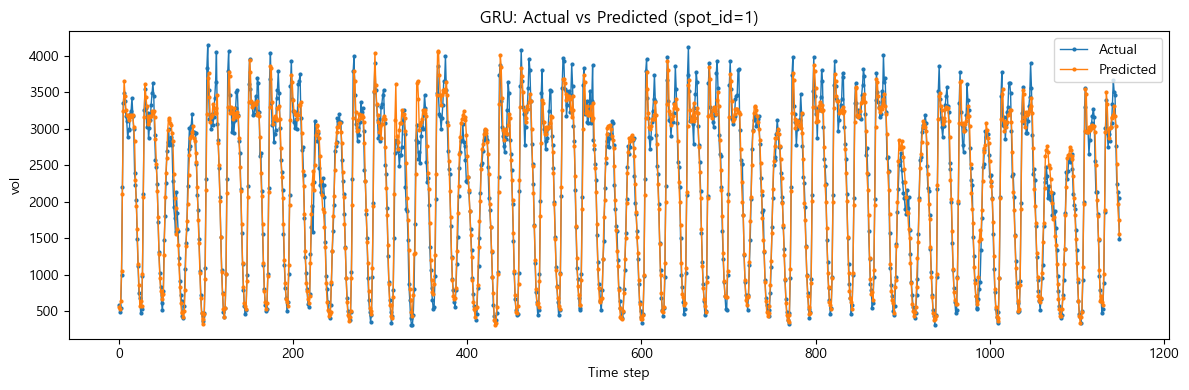

In [ ]:
import numpy as np

spot_pick = int(np.bincount(s_te).argmax())  # 테스트에서 가장 많은 spot
mask = (s_te == spot_pick)

y_true_spot = y_true[mask]
y_pred_spot = y_pred_gru[mask]

plt.figure(figsize=(12,4))
plt.plot(y_true_spot, label="Actual", marker="o", markersize=2, linewidth=1)
plt.plot(y_pred_spot, label="Predicted", marker="o", markersize=2, linewidth=1)
plt.title(f"GRU: Actual vs Predicted (spot_id={spot_pick})")
plt.xlabel("Time step")
plt.ylabel("vol")
plt.legend()
plt.tight_layout()
plt.savefig(REPORTS / f"pred_vs_actual_gru_spot{spot_pick}.png", dpi=200)
plt.show()


In [ ]:
import math
from sklearn.metrics import mean_absolute_error, mean_squared_error

def mape(y_true, y_pred, eps=1e-6):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)
    denom = np.maximum(np.abs(y_true), eps)
    return np.mean(np.abs((y_true - y_pred) / denom)) * 100.0

def eval_regression(y_true, y_pred):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    mp = mape(y_true, y_pred)
    return {"MAE": mae, "RMSE": rmse, "MAPE": mp}


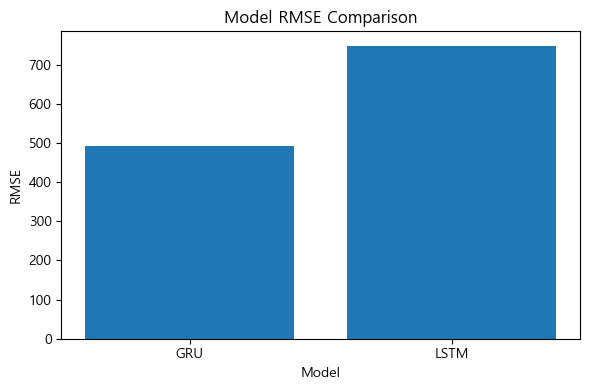

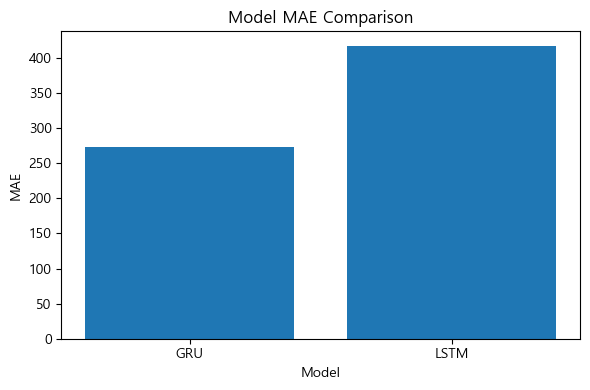

In [ ]:
import matplotlib.pyplot as plt

# 공통 y_true (이미 위에서 만들었으면 그대로 사용)


y_pred_scaled_lstm = lstm_model.predict([Xte_seq, s_te], batch_size=256, verbose=0).reshape(-1)
y_pred_lstm = inverse_target_if_needed(y_pred_scaled_lstm, meta_rnn)

y_true = inverse_target_if_needed(yte_rnn.reshape(-1), meta_rnn)

metrics_rows = []
metrics_rows.append({"model": "LSTM", **eval_regression(y_true, y_pred_lstm)})
metrics_rows.append({"model": "GRU",  **eval_regression(y_true, y_pred_gru)})

metrics_df = pd.DataFrame(metrics_rows).sort_values("RMSE").reset_index(drop=True)
metrics_df

# RMSE
plt.figure(figsize=(6,4))
plt.bar(metrics_df["model"], metrics_df["RMSE"])
plt.title("Model RMSE Comparison")
plt.xlabel("Model")
plt.ylabel("RMSE")
plt.tight_layout()
plt.savefig(REPORTS / "bar_rmse_models.png", dpi=200)
plt.show()

# MAE
plt.figure(figsize=(6,4))
plt.bar(metrics_df["model"], metrics_df["MAE"])
plt.title("Model MAE Comparison")
plt.xlabel("Model")
plt.ylabel("MAE")
plt.tight_layout()
plt.savefig(REPORTS / "bar_mae_models.png", dpi=200)
plt.show()


In [29]:
# --- XGBoost train & eval ---
try:
    from xgboost import XGBRegressor
    XGB_AVAILABLE = True
except Exception:
    XGB_AVAILABLE = False

if not XGB_AVAILABLE:
    raise RuntimeError("xgboost가 설치되어 있지 않습니다. (pip install xgboost)")

def define_xgb_model(random_state=42):
    return XGBRegressor(
        n_estimators=800,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.9,
        colsample_bytree=0.9,
        objective="reg:squarederror",
        random_state=random_state,
        n_jobs=0,
        importance_type="gain",
    )

# raw windows 로드 (XGB는 raw npz 사용)
Xtr_raw, ytr_raw, Xva_raw, yva_raw, Xte_raw, yte_raw, feat_cols_raw, meta_raw = load_npz(npz_raw)

# flatten (N, T, F) -> (N, T*F)
Xtr_f = Xtr_raw.reshape(Xtr_raw.shape[0], -1)
Xva_f = Xva_raw.reshape(Xva_raw.shape[0], -1)
Xte_f = Xte_raw.reshape(Xte_raw.shape[0], -1)

ytr_f = ytr_raw.reshape(-1)
yva_f = yva_raw.reshape(-1)
yte_f = yte_raw.reshape(-1)

xgb_model = define_xgb_model()
xgb_model.fit(
    Xtr_f, ytr_f,
    eval_set=[(Xva_f, yva_f)],
    verbose=False
)

y_pred_xgb = xgb_model.predict(Xte_f)
m_xgb = eval_regression(yte_f, y_pred_xgb)

m_xgb


KeyboardInterrupt: 

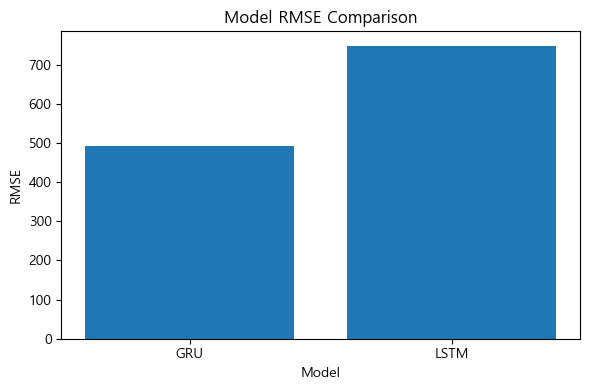

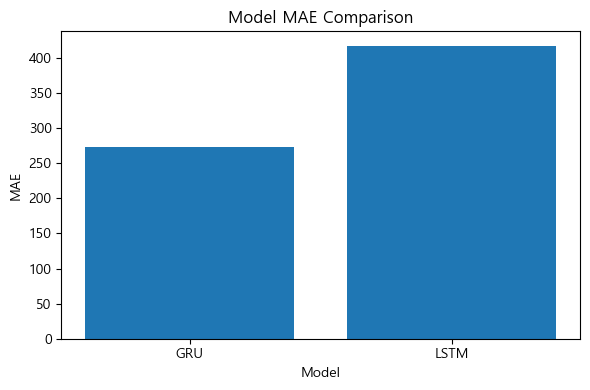

In [ ]:
import matplotlib.pyplot as plt

# 공통 y_true (이미 위에서 만들었으면 그대로 사용)


y_pred_scaled_lstm = lstm_model.predict([Xte_seq, s_te], batch_size=256, verbose=0).reshape(-1)
y_pred_lstm = inverse_target_if_needed(y_pred_scaled_lstm, meta_rnn)

y_true = inverse_target_if_needed(yte_rnn.reshape(-1), meta_rnn)

metrics_rows = []
metrics_rows.append({"model": "LSTM", **eval_regression(y_true, y_pred_lstm)})
metrics_rows.append({"model": "GRU",  **eval_regression(y_true, y_pred_gru)})

metrics_df = pd.DataFrame(metrics_rows).sort_values("RMSE").reset_index(drop=True)
metrics_df

# RMSE
plt.figure(figsize=(6,4))
plt.bar(metrics_df["model"], metrics_df["RMSE"])
plt.title("Model RMSE Comparison")
plt.xlabel("Model")
plt.ylabel("RMSE")
plt.tight_layout()
plt.savefig(REPORTS / "bar_rmse_models.png", dpi=200)
plt.show()

# MAE
plt.figure(figsize=(6,4))
plt.bar(metrics_df["model"], metrics_df["MAE"])
plt.title("Model MAE Comparison")
plt.xlabel("Model")
plt.ylabel("MAE")
plt.tight_layout()
plt.savefig(REPORTS / "bar_mae_models.png", dpi=200)
plt.show()


In [ ]:
# test_df는 hourly 데이터 split 결과
# (앞에서 time_split_hourly로 만든 test_df 사용)

m_last_value = naive_last_value(test_df)
m_last_week  = naive_last_week(test_df)

m_last_value, m_last_week


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# metrics_df는 이전 단계에서 만든 DataFrame 사용
# columns: model | MAE | RMSE | MAPE

metrics_plot = metrics_df.copy()
metrics_plot = metrics_plot[["model", "RMSE", "MAE"]]

metrics_plot


,model,RMSE,MAE
0,GRU,493.954673,273.592163
1,LSTM,748.420420,417.026520


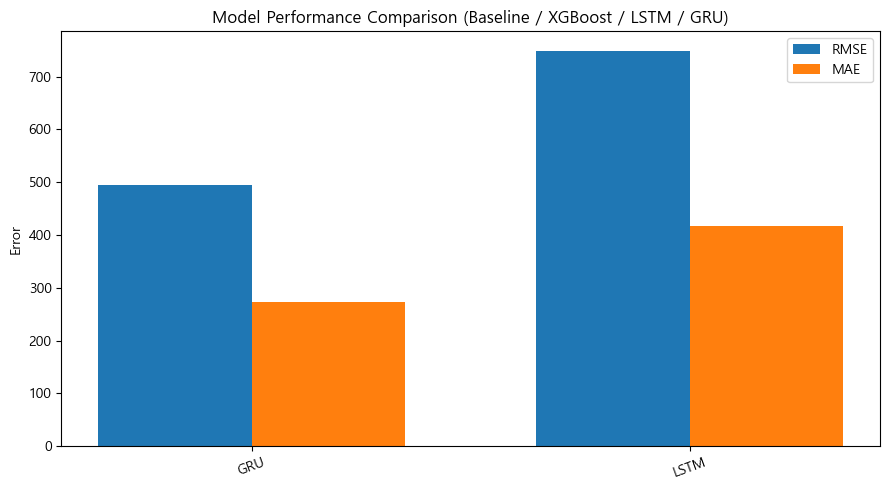

In [ ]:
x = np.arange(len(metrics_plot["model"]))
width = 0.35

plt.figure(figsize=(9,5))

plt.bar(x - width/2, metrics_plot["RMSE"], width, label="RMSE")
plt.bar(x + width/2, metrics_plot["MAE"],  width, label="MAE")

plt.xticks(x, metrics_plot["model"], rotation=20)
plt.ylabel("Error")
plt.title("Model Performance Comparison (Baseline / XGBoost / LSTM / GRU)")
plt.legend()

plt.tight_layout()
plt.savefig("reports/bar_rmse_mae_all_models.png", dpi=200)
plt.show()


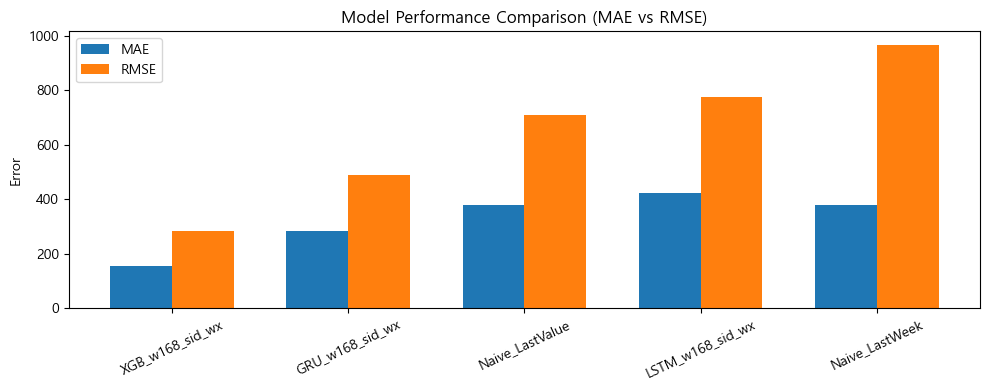

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# metrics 파일 경로
path = "reports/metrics_w168_sid_wx.csv"
df = pd.read_csv(path)

# RMSE 기준 정렬 (가독성 ↑)
df = df.sort_values("RMSE")

models = df["model"]
mae = df["MAE"]
rmse = df["RMSE"]

x = np.arange(len(models))
width = 0.35

plt.figure(figsize=(10, 4))
plt.bar(x - width/2, mae, width, label="MAE")
plt.bar(x + width/2, rmse, width, label="RMSE")

plt.xticks(x, models, rotation=25)
plt.ylabel("Error")
plt.title("Model Performance Comparison (MAE vs RMSE)")
plt.legend()
plt.tight_layout()
plt.show()
